# Classification

## Imports

In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from importlib import reload

import numpy as np
import pandas as pd
import optree

import torch
import torch.nn as nn

# For development mode
import astra
reload(astra.torch.data)
reload(astra.torch.models)
reload(astra.torch.utils)
reload(astra.torch.metrics)

from astra.torch.data import load_cifar_10
from astra.torch.models import ResNetClassifier, EfficientNetClassifier, DenseNetClassifier
from astra.torch.utils import train_fn, count_params
from astra.torch.metrics import classification_report

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data 

In [13]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
range of image values: min=0.0, max=1.0
            

In [14]:
dataset.data.shape, dataset.targets.shape

(torch.Size([60000, 3, 32, 32]), torch.Size([60000]))

### Visualize a few images

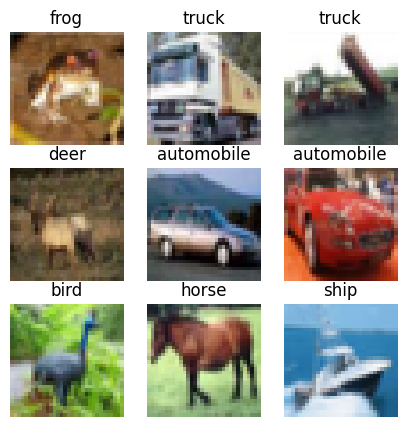

In [15]:
few_images = dataset.data[:10]
few_targets = dataset.targets[:10]

fig, ax = plt.subplots(3, 3, figsize=(5, 5))
ax = ax.flatten()
for i in range(9):
    ax[i].set_axis_off()
    ax[i].imshow(few_images[i].permute(1, 2, 0))
    ax[i].set_title(dataset.classes[few_targets[i]])

## Train-test split

In [16]:
n_train = int(len(dataset) * 0.8)
idx = torch.randperm(len(dataset))

train_x, train_y = dataset.data[idx[:n_train]], dataset.targets[idx[:n_train]]
test_x, test_y = dataset.data[idx[n_train:]], dataset.targets[idx[n_train:]]

train_x.shape, train_y.shape, test_x.shape, test_y.shape

(torch.Size([48000, 3, 32, 32]),
 torch.Size([48000]),
 torch.Size([12000, 3, 32, 32]),
 torch.Size([12000]))

## Training

In [17]:
clf_dict = {"efficientnet": EfficientNetClassifier(n_classes=10), "resnet": ResNetClassifier(n_classes=10), "densenet": DenseNetClassifier(n_classes=10)}

for clf_name, clf in clf_dict.items():
    print(f"Training {clf_name}...")
    train_fn(clf.to(device), nn.CrossEntropyLoss(), train_x, train_y, lr=1e-3, batch_size=1024, epochs=20)
    clf.to("cpu")

Training efficientnet...


Loss: 0.03868497: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]


Training resnet...


Loss: 0.02470850: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Training densenet...


Loss: 0.02415494: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


In [22]:
pd.DataFrame(optree.tree_map(count_params, clf_dict)).T

,total_params,trainable_params,non_trainable_params
efficientnet,4668550,4668550,0
resnet,11444298,11444298,0
densenet,7483786,7483786,0


## Evaluation

In [23]:
result_dict = {}
for clf_name, clf in clf_dict.items():
    clf.to(device)
    pred_y = clf.predict_class(test_x, batch_size=1024).to("cpu")
    result_dict[clf_name] = optree.tree_map(lambda x: x.item(), classification_report(test_y, pred_y))
    
pd.DataFrame(result_dict).T.style.format("{:.2f}").highlight_max(axis=0, color="green")

 33%|███▎      | 4/12 [00:00<00:00, 30.60it/s]

100%|██████████| 12/12 [00:00<00:00, 13.24it/s]


,accuracy,precision,recall,f1
efficientnet,0.82,0.93,0.87,0.90
resnet,0.81,0.85,0.94,0.89
densenet,0.85,0.90,0.95,0.93
